In [1]:
%matplotlib inline
import tensorflow as tf
import skimage
import skimage.io
import skimage.transformz
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
img = skimage.io.imread('train/cat.10012.jpg')

In [3]:
img.shape

(166, 250, 3)

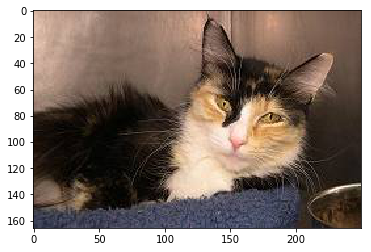

In [4]:
plt.imshow(img)

In [5]:
short_edge = min(img.shape[:2])

In [6]:
short_edge

166

In [7]:
yy = int((img.shape[0] - short_edge) / 2)
xx = int((img.shape[1] - short_edge) / 2)
crop_img = img[yy: yy + short_edge, xx: xx + short_edge]

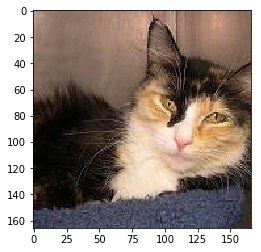

In [8]:
plt.imshow(crop_img)

In [9]:
crop_img.shape

(166, 166, 3)

In [10]:
resized_img = skimage.transform.resize(crop_img, (224,224), mode='constant')

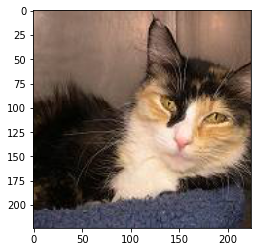

In [11]:
plt.imshow(resized_img)

In [12]:
type(resized_img)

numpy.ndarray

In [13]:
img3=Image.open('train/cat.10012.jpg')

In [14]:
type(img3)

PIL.JpegImagePlugin.JpegImageFile

## Game Begin

In [14]:
import glob
import os.path
import random
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile
from sklearn.model_selection import StratifiedShuffleSplit

In [15]:
BOTTLENECK_TENSOR_SIZE = 2048
BOTTLENECK_TENSOR_NAME = 'pool_3/_reshape:0'
JPEG_DATA_TENSOR_NAME = 'DecodeJpeg/contents:0'
MODEL_DIR = 'model/'
MODEL_FILE = 'tensorflow_inception_graph.pb'

#### 因为一个训练数据会被使用多次，所以可以将原始图像通过Inception-v3模型计算得到的特征向量保存在文件中，免去重复的计算。
#### 下面的变量定义了这些文件的存放地址。

In [16]:
CACHE_DIR = 'tmp/bottleneck/'

In [17]:
INPUT_DATA = 'train/'
VALIDATION_PERCENTAGE = 10
TEST_PERCENTAGE = 10

In [18]:
LEARNING_RATE = 0.001
EPOCHS = 10 #400
BATCH_SIZE= 1000

In [19]:
def run_bottleneck_on_image(sess, image_data, image_data_tensor, bottleneck_tensor):
    bottleneck_values = sess.run(bottleneck_tensor, {image_data_tensor: image_data})
    bottleneck_values = np.squeeze(bottleneck_values) # 经过卷积神经网络处理的结果是一个四维数组，需要将这个结果压缩成一个特征向量（一维数组）
    return bottleneck_values

In [20]:
def create_bottleneck(sess, input_data, cache_dir, jpeg_data_tensor, bottleneck_tensor):
    image_list = [x for x in os.listdir(input_data)]
    for image in image_list:
        bottleneck_path = cache_dir + image[:-3] + 'txt'
        image_path = os.path.join(input_data,image)
        image_data = gfile.FastGFile(image_path, 'rb').read()
        bottleneck_values = run_bottleneck_on_image(sess,image_data,jpeg_data_tensor,bottleneck_tensor)
        bottleneck_string = ','.join(str(x) for x in bottleneck_values)
        with open(bottleneck_path, 'w') as bottleneckfile:
            bottleneckfile.write(bottleneck_string)

In [21]:
def shuffle_and_split_bottleneck():
    '''
    :Shuffled and split bottleneck from Cached directory
    :Return shuffled bottleneck file name numpy ndarray
    '''
    codes = np.array([code for code in os.listdir(CACHE_DIR)])
    labels = np.array([code[:3] for code in codes])
    ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    train_idx, val_idx = next(ss.split(codes,labels))
    half_val_len = int(len(val_idx)/2)
    val_idx, test_idx = val_idx[:half_val_len],val_idx[half_val_len:]
    
    train_x, train_y = codes[train_idx], labels[train_idx]
    val_x, val_y = codes[val_idx], labels[val_idx]
    test_x, test_y = codes[test_idx], labels[test_idx]
    return train_x, train_y, val_x, val_y, test_x, test_y

In [22]:
def get_batches(x, y, cache_dir, batch_size=BATCH_SIZE): # x是bottleneck所对应的名字的一个list，如‘dog.1023.txt’；y是类别所对应的名字的list，如‘dog’
    batch_num = len(x) // batch_size
    for ii in range(0, batch_num * batch_size, batch_size):
        if ii != (batch_num - 1) * batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size]
        else:
            X, Y = x[ii:], y[ii:]
        ''''
        bottlenecks = []
        labels = []
        for i in range(len(X)):
            with open(os.path.join(CACHE_DIR,X[i]),'r') as bottleneck_file:
                bottlenecks.append([float(xx) for xx in bottleneck_file.read().split(',')])
            labels.append([1 if Y[i] == 'dog' else 0])
        '''
        bottlenecks, labels = get_bottleneck_from_file(X, Y, cache_dir)
        yield bottlenecks, labels

In [23]:
def get_bottleneck_from_file(x,y,cache_dir):
    bottlenecks = []
    labels = []
    for i in range(len(x)):
        with open(os.path.join(cache_dir,x[i]),'r') as bottleneck_file:
            bottlenecks.append([float(xx) for xx in bottleneck_file.read().split(',')])
        labels.append([1 if y[i] == 'dog' else 0])
    return np.array(bottlenecks), np.array(labels)

In [24]:
# get final outcome
FINAL_DATA_DIR='test/'
FINAL_CACHE_DIR='tmp/final_bottleneck/'

In [25]:
def main(_):
    # 读取已经训练好的 Inception-v3 模型
    with gfile.FastGFile(os.path.join(MODEL_DIR, MODEL_FILE), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    # 加载读取的Inception-v3模型，并返回数据输入所对应的张量以及计算瓶颈层结果所对应的张量
    bottleneck_tensor, jpeg_data_tensor = tf.import_graph_def(graph_def, return_elements=[BOTTLENECK_TENSOR_NAME, JPEG_DATA_TENSOR_NAME])


    # 定义新的神经网络输入，这个输入就是新的图片经过Inception-v3模型前向传播到达瓶颈层时的结点取值
    bottleneck_input = tf.placeholder(tf.float32, [None, BOTTLENECK_TENSOR_SIZE], name='BottleneckInputPlaceholder')
    # 定义新的标准答案输入
    ground_truth_input = tf.placeholder(tf.float32, [None, 1], name='GroundTruthInput')
    # 定义全连接层来解决新的图片分类问题
    fc1 = tf.layers.dense(bottleneck_input,256,activation=tf.nn.sigmoid, \
                          kernel_initializer=tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))
    logits = tf.layers.dense(fc1,1)
    predictions = tf.nn.sigmoid(logits)
    
    # 定义交叉熵损失函数
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=ground_truth_input)
    cost = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(cost)
    
    # 计算正确率
    with tf.name_scope('evaluation'):
        correct_prediction = tf.equal(tf.cast(tf.round(predictions),tf.float32), ground_truth_input)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
            
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        if not os.listdir(CACHE_DIR):
            create_bottleneck(sess, INPUT_DATA, CACHE_DIR, jpeg_data_tensor, bottleneck_tensor)
        train_x, train_y, val_x, val_y, test_x, test_y = shuffle_and_split_bottleneck()
        
        for e in range(EPOCHS):
            for train_bottlenecks, train_labels in get_batches(train_x, train_y, CACHE_DIR):
                costs,_ = sess.run([cost,optimizer], feed_dict={bottleneck_input: train_bottlenecks, ground_truth_input: train_labels})
            
                if e % 1000 == 0 or e+1 == EPOCHS:
                    validation_bottleneck, validation_labels = get_bottleneck_from_file(val_x, val_y, CACHE_DIR)
                    validation_accuracy = sess.run(accuracy, feed_dict={bottleneck_input: validation_bottleneck, ground_truth_input: validation_labels})
                    print('Epoch: {}   Training cost: {:.4f}   Validation Accuracy: {:.4f}'.format(e,costs,validation_accuracy))
                
        test_bottleneck, test_labels = get_bottleneck_from_file(test_x, test_y, CACHE_DIR)
        test_accuracy = sess.run(accuracy, feed_dict={bottleneck_input: test_bottleneck, ground_truth_input: test_labels})
        print('Final test accuracy = {:.3f}'.format(test_accuracy))
        
        # Get final outcome
        if not os.listdir(FINAL_CACHE_DIR):
            create_bottleneck(sess, FINAL_DATA_DIR, FINAL_CACHE_DIR, jpeg_data_tensor, bottleneck_tensor)
        final_x = np.array(os.listdir(FINAL_CACHE_DIR))
        final_bottleneck, _ = get_bottleneck_from_file(final_x, final_x, FINAL_CACHE_DIR)
        pred    = sess.run(predictions, feed_dict={bottleneck_input: final_bottleneck})
        
        pred_array = np.squeeze(pred)
        for i in range(len(pred_array)):
            value_string = ','.join([str(final_x[i][:-4]),str(pred_array[i])])
            with open('final_outcome','a') as f:
                f.write(value_string+'\n')

In [26]:
if __name__ == '__main__':
    tf.app.run()

Epoch: 0   Training cost: 0.8169   Validation Accuracy: 0.5252
Epoch: 0   Training cost: 0.6831   Validation Accuracy: 0.5512
Epoch: 0   Training cost: 0.5908   Validation Accuracy: 0.9132
Epoch: 0   Training cost: 0.4450   Validation Accuracy: 0.9676
Epoch: 0   Training cost: 0.3592   Validation Accuracy: 0.9404
Epoch: 0   Training cost: 0.3374   Validation Accuracy: 0.9516
Epoch: 0   Training cost: 0.2714   Validation Accuracy: 0.9700
Epoch: 0   Training cost: 0.2150   Validation Accuracy: 0.9832
Epoch: 0   Training cost: 0.1777   Validation Accuracy: 0.9892
Epoch: 0   Training cost: 0.1545   Validation Accuracy: 0.9912
Epoch: 0   Training cost: 0.1391   Validation Accuracy: 0.9920
Epoch: 0   Training cost: 0.1285   Validation Accuracy: 0.9924
Epoch: 0   Training cost: 0.1144   Validation Accuracy: 0.9912
Epoch: 0   Training cost: 0.0973   Validation Accuracy: 0.9908
Epoch: 0   Training cost: 0.0948   Validation Accuracy: 0.9896
Epoch: 0   Training cost: 0.0811   Validation Accuracy:

SystemExit: 

/home/max/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
